In [2]:
import sys
import dawis as d
import glob as glob
import os
import numpy as np
import pyregion as pyr
import random
import gc
import h5py
import dawis
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy.visualization import *
from scipy.stats import kurtosis
from power_ratio import *
from datetime import datetime
from photutils.segmentation import SourceCatalog, detect_sources
from photutils.background import Background2D, MedianBackground
import make_results_ERO_noray
import tracemalloc
import matplotlib
import cmasher
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle
from astropy.stats import sigma_clip, SigmaClip
import subprocess


In [7]:
# Paths, lists & variables
path_data = '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/'
path_sub_data = '/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction'
path_scripts = '/home/aellien/Euclid_ERO/Euclid_ERO_scripts'
path_wavelets = '/home/aellien/Euclid_ERO/wavelets/out13/'
path_plots = '/home/aellien/Euclid_ERO/plots'
path_analysis = '/home/aellien/Euclid_ERO/analysis/'

hdu = fits.open('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.masked.rot.crop.warp.input.fits')
header = hdu[0].header
oim = hdu[0].data
xs, ys = oim.shape

In [5]:
# Make same image without masking
nfdl = [ {'infile':'Final_output_JGM_Abellfinal_psf_sub_Hv1_Callummock.fits', 'filter':'H'},
        {'infile':'Final_output_JGM_Abellfinal_psf_sub_Jv1_vC1_v21.fits', 'filter':'J'}, 
        {'infile':'Final_output_JGM_Abellfinal_psf_sub_Hv1_vC1_v24.fits', 'filter':'H'},
        {'infile':'Final_output_JGM_Abellfinal_psf_sub_Yv1_vC1_v21.fits', 'filter':'Y'} ]
for nfd in nfdl:
    
    print(nfd['infile'])
    infile = os.path.join(path_sub_data, nfd['infile'])
    hdu = fits.open(infile)
    oim, header = hdu[0].data, hdu[0].header

    # rot
    rot = infile[:-4]+'rot.fits'
    subprocess.run(['astwarp', '--rotate=295', '-h0', infile, '--output=%s'%rot])

    # crop
    crop = rot[:-4]+'crop.fits'
    subprocess.run(['astcrop', '--mode=wcs', '--center=328.40009,17.699051', '--width=0.75,0.75', '-h1', '--output=%s'%crop, rot])

    # warp
    warp = crop[:-4]+'warp.fits'
    subprocess.run(['astwarp', '--scale=1./4.', '-h1', '--output=%s'%warp, crop])

    # dawis input rdy
    input = warp[:-4]+'input.fits'
    subprocess.run(['astfits', warp, '--copy=1', '--output=%s'%input, '--primaryimghdu'])

print('done')

Final_output_JGM_Abellfinal_psf_sub_Hv1_Callummock.fits
Warp 0.21 started on Mon Jul 29 22:26:03 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Hv1_Callummock.fits (hdu: 0)
 matrix:
	 0.4226    0.9063    0.0000
	-0.9063    0.4226    0.0000
	 0.0000    0.0000    1.0000
 Output: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abellfinal_psf_sub_Hv1_Callummock.rot.fits
Warp finished in:  17.965971 seconds
Crop 0.21 started on Mon Jul 29 22:26:21 2024
  - Read metadata of 1 dataset.                        0.000882 seconds
  ---- ...v1_Callummock.rot.crop.fits created: 1 input.
Crop finished in:  1.138486 seconds
Warp 0.21 started on Mon Jul 29 22:26:22 2024
 Using 20 CPU threads.
 Input: /home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Abell2390_NISP_starsubtraction/Final_output_JGM_Abell

In [10]:
nfp = os.path.join(path_wavelets, 'Final_output_JGM_Abellfinal_psf_sub_Hv1_vC1_v24.rot.crop.warp.input.')
opath = nfp + '*ol.it*.hdf5'
opathl = glob.glob(opath)
opathl.sort()

cirim3 = np.zeros((xs, ys))
cirim4 = np.zeros((xs, ys))
cirim5 = np.zeros((xs, ys))
cirim6 = np.zeros((xs, ys))
cirim7 = np.zeros((xs, ys))
derim3 = np.zeros((xs, ys))
derim4 = np.zeros((xs, ys))
derim5 = np.zeros((xs, ys))
derim6 = np.zeros((xs, ys))
derim7 = np.zeros((xs, ys))
recim = np.zeros((xs, ys))

# avoid cluster region
hdu = fits.open(os.path.join(path_data, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.fits'))
oim, header = hdu[0].data, hdu[0].header
r = pyr.open(os.path.join(path_analysis, 'cluster_cirrus_mask_NISP_pix.reg'))
mcl = r.get_mask(hdu = hdu[0])

for i in range(23, 211):
    print(i, end = '\r')
    op = nfp + 'ol.it%03d.hdf5'%i
    with h5py.File(op, "r") as f1:
        for o in f1.keys():
            gc.collect()
            x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
            image = np.copy(f1[o]['image'][()])
            det_err_image = np.copy(f1[o]['det_err_image'][()])
            m = detect_sources(image, threshold = 0., npixels=1)
            c = SourceCatalog(image, m)
            xco = int(c.centroid_quad[0][1] + x_min)
            yco = int(c.centroid_quad[0][0] + y_min)
            xco = np.unravel_index(image.argmax(), image.shape)[0] + x_min
            yco = np.unravel_index(image.argmax(), image.shape)[1] + y_min
            lvlo = np.copy(f1[o]['level'][()])

            recim[ x_min : x_max, y_min : y_max ] += image
            
            
            if (lvlo == 3) & (mcl[xco, yco] != True):
                cirim3[ x_min : x_max, y_min : y_max ] += image
                derim3[ x_min : x_max, y_min : y_max ] += det_err_image
            if (lvlo == 4) & (mcl[xco, yco] != True):
                cirim4[ x_min : x_max, y_min : y_max ] += image
                derim4[ x_min : x_max, y_min : y_max ] += det_err_image
            if (lvlo == 5) & (mcl[xco, yco] != True):
                cirim5[ x_min : x_max, y_min : y_max ] += image
                derim5[ x_min : x_max, y_min : y_max ] += det_err_image
            if (lvlo == 6) & (mcl[xco, yco] != True):
                cirim6[ x_min : x_max, y_min : y_max ] += image
                derim6[ x_min : x_max, y_min : y_max ] += det_err_image
            if lvlo >= 7:
                cirim7[ x_min : x_max, y_min : y_max ] += image
                derim7[ x_min : x_max, y_min : y_max ] += det_err_image
cirim = cirim5+cirim6+cirim7
derim = derim5+derim6+derim7
print('done')

done


In [ ]:
cirim = cirim5+cirim6+cirim7
derim = derim5+derim6+derim7

In [12]:
hdu = fits.open(os.path.join(path_data, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.fits'))
oim, header = hdu[0].data, hdu[0].header
noise_pixels, val_max = dawis.sample_noise(oim, n_sigmas = 3, bins = 300)
hduo = fits.PrimaryHDU()
hdu_oim = fits.ImageHDU(oim, header = header, name = 'ORIGINAL')
hdu_cirim = fits.ImageHDU(cirim + val_max, header = header, name = 'CIRRUS')
hdu_derim = fits.ImageHDU(derim, header = header, name = 'RMS')
hdu_clean = fits.ImageHDU(oim - cirim, header = header, name = 'CLEANED')
hdu_recim = fits.ImageHDU(recim, header = header, name = 'RECIM')
hdu_res = fits.ImageHDU(oim - recim, header = header, name = 'RES')

hdul = fits.HDUList([hduo, hdu_oim, hdu_clean, hdu_cirim, hdu_derim, hdu_recim, hdu_res])
hdul.writeto(nfp + 'synth.cirrus_lvl5.fits', overwrite = True)

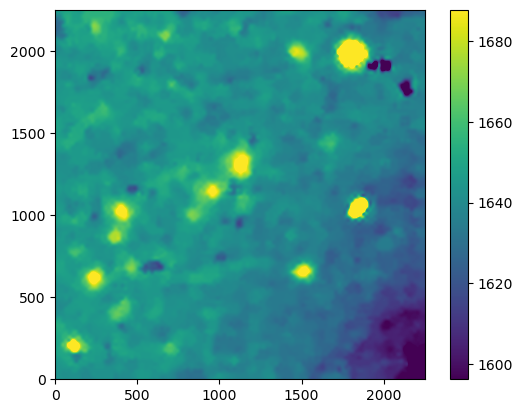

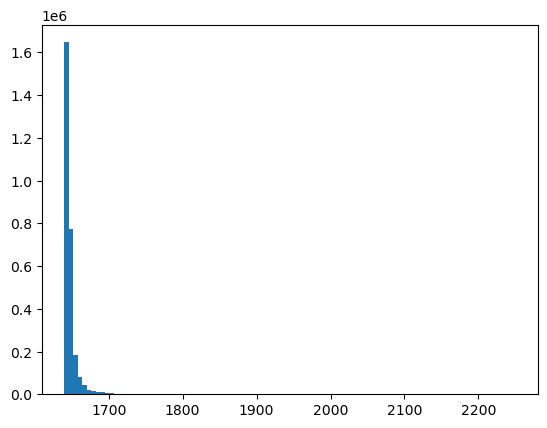

In [19]:
# rewrite input for 2nd pass
for infile in glob.glob(os.path.join(path_wavelets, 'Final_output_JGM_Abellfinal_psf_sub_Hv1_vC1_v24.rot.crop.warp.input.synth.cirrus_lvl5.fits')):
    hduo, hdu_oim, hdu_clean, hdu_cirim, hdu_derim, hdu_recim, hdu_res = fits.open(infile)
    res = hdu_res.data
    cirim = hdu_cirim.data
    derim = hdu_derim.data
    recim = hdu_recim.data

    hdu = fits.open(os.path.join(path_data, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.fits'))
    oim, header = hdu[0].data, hdu[0].header
    noise_pixels, val_max = dawis.sample_noise(oim, n_sigmas = 3, bins = 300)

    sigma_clip = SigmaClip(sigma = 3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(res, (20, 20), filter_size=(3, 3), sigma_clip = sigma_clip, bkg_estimator=bkg_estimator)
    plt.figure()
    plt.imshow(bkg.background, origin = 'lower', norm = ImageNormalize( bkg.background, interval = ZScaleInterval(), stretch = LinearStretch() ) )#
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.hist(bkg.background.flatten(), bins = 100, range = (1640, 2250))
    plt.show()

    hduo = fits.PrimaryHDU()
    hdu_cirim = fits.ImageHDU(cirim + bkg.background - val_max, header = header, name = 'CIRRUS')
    hdu_clean = fits.ImageHDU(oim - cirim + val_max - bkg.background, header = header, name = 'CLEANED')
    hdu_recim = fits.ImageHDU(recim + bkg.background - val_max, header = header, name = 'RECIM')
    hdu_res = fits.ImageHDU(oim - recim - bkg.background + val_max, header = header, name = 'RES')    
    
    hdul = fits.HDUList([hduo, hdu_oim, hdu_clean, hdu_cirim, hdu_recim, hdu_res])
    hdul.writeto(os.path.join(path_wavelets, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_res_altpass2.fits'), overwrite = True)
  

In [15]:
os.path.join(path_wavelets, 'Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_lvl5.fits')

'/home/aellien/Euclid_ERO/wavelets/out13/Euclid-NISP-H-ERO-Abell2390-LSB.DR3.rot.crop.warp.input.synth.cirrus_lvl5.fits'